In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
from scipy import stats

In [2]:
#Read CSV file, convert to dataframe
drg_master = pd.read_csv('data/Inpatient_PYMT_IPPS_DRG_FY2017_CLEAN.csv')
centroids = pd.read_csv('data/state_centroids.csv')
census_master = pd.read_csv('data/state_census_data.csv')
centroids.head(2)

,State,State_Abb,Latitude,Longitude
0,Alabama,AL,32.7794,-86.8287
1,Alaska,AK,64.0685,-152.2782


In [3]:
#Cleanup Column Names
drg_master = drg_master.rename(columns={'DRG Definition': 'DRG', 'Provider Name': 'Name', 'Provider City': 'City',
                                       'Provider State': 'State', 'Provider Zip Code': 'Zip Code',
                                       'Hospital Referral Region (HRR) Description': 'Region', 'Total Discharges': 'Discharges',
                                       'Average Covered Charges': 'List Price', 'Average Total Payments': 'Average Total',
                                       'Average Medicare Payments': 'Average Medicare'})
drg_master.head(2)

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare
0,291 - HEART FAILURE & SHOCK W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,371,34642.05,7771.63,6965.86
1,291 - HEART FAILURE & SHOCK W MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,89,18208.90,8220.40,6905.46


In [4]:
#Data Munging - inner merge drg master with State-level centroids, census data
centroids.rename(columns={'State': 'St', 'State_Abb':'State'},inplace=True)
test = pd.merge(drg_master, centroids, on='State', how='inner')
drg_master = pd.merge (test, census_master, on='State', how='inner')

#output
drg_master.to_csv('data/drg_updated.csv',encoding='utf-8')

In [5]:
#Hive off Diabetes and Joint Replacement procedures to new dataframes
diabetes_master = drg_master.loc[drg_master['DRG'] == '638 - DIABETES W CC']
joint_master = drg_master.loc[drg_master['DRG'] == '470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC']
#Create average and st_dev dataframes, sorted by descending
diabetes_stdev = diabetes_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)
diabetes_avgtotal = diabetes_master.groupby('State').mean().dropna()

joint_avgtotal = joint_master.groupby('State').mean().dropna()
joint_stdev = joint_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)

joint_stdev.sort_values(by=['List Price'], ascending=False).head()

,List Price,Average Total,Average Medicare,Latitude_x,Longitude_x,State_x,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,Latitude_y,Longitude_y
State,,,,,,,,,,,,,,,
NJ,41810.022426,2657.479731,2367.535363,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA,41705.759932,2660.811687,1961.134143,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL,41174.244130,1229.727356,883.661471,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TX,39680.379792,3376.700300,3103.205685,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MS,37888.490810,1180.599607,1063.350674,4.799242,9.000342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Print Diabetes Std_Dev sorted by List Price (covered charges)
diabetes_stdev.sort_values(by=['List Price'], ascending=False).head()

,List Price,Average Total,Average Medicare,Latitude_x,Longitude_x,State_x,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,Latitude_y,Longitude_y
State,,,,,,,,,,,,,,,
NJ,20505.761289,1576.911330,1175.678073,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA,18309.857682,2520.417512,2369.803427,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA,16235.911976,1842.524003,1152.329736,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MS,15669.649654,881.033853,760.091397,4.811989,9.024247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL,15274.962317,693.668359,465.921945,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#More Data Munging - add Centroid coordinates by state level, re-add to St_Dev and Average group-by dataframes
joint_stdev.reset_index(level=0, inplace=True)
joint_avgtotal.reset_index(level=0, inplace=True)
diabetes_stdev.reset_index(level=0, inplace=True)
diabetes_avgtotal.reset_index(level=0, inplace=True)
#centroids.rename(columns={'State': 'St', 'State_Abb':'State'})

joint_stdev = pd.merge(joint_stdev, centroids, on='State', how='inner')
diabetes_stdev = pd.merge(diabetes_stdev, centroids, on='State', how='inner')
joint_avgtotal = pd.merge(joint_avgtotal, centroids, on='State', how='inner')
diabetes_avgtotal = pd.merge(diabetes_avgtotal, centroids, on='State', how='inner')

#joint_stdev.drop_duplicates(keep=False,inplace=True) 

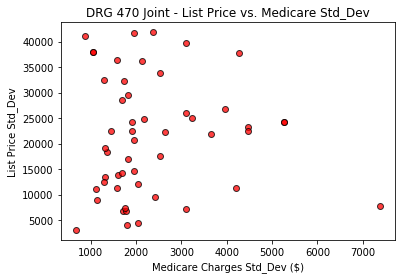

In [8]:
# Joints - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 470 Joint - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['List Price'], marker="o", facecolors="red", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_list_medicare.png')

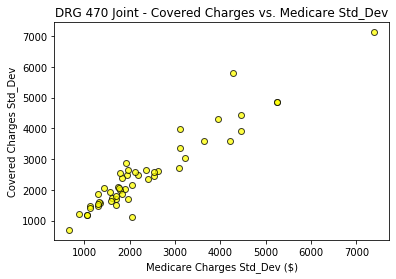

In [9]:
# Joints - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 470 Joint - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['Average Total'], marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_covered_medicare.png')

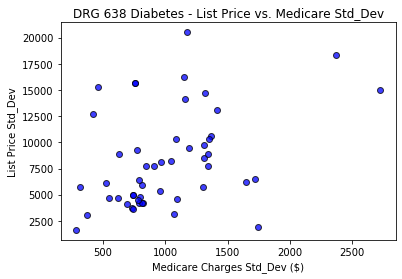

In [10]:
# Diabetes - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 638 Diabetes - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['List Price'], marker="o", facecolors="blue", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_list_medicare.png')

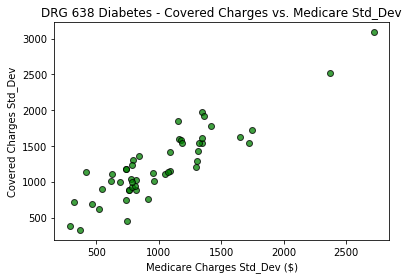

In [11]:
# Diabetes - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 638 Diabetes - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['Average Total'], marker="o", facecolors="green", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_covered_medicare.png')

In [12]:
#Examine Mississippi, Diabetes
diabetes_state_list = []
diabetes_state_medicare = []
diabetes_zipcode = []

#diabetes_master.drop_duplicates(subset = 'Provider Id', keep = 'first', inplace = True)

for i in range (len(diabetes_master)):
    if diabetes_master.iloc[i]['State'] == 'MS':
        diabetes_state_list.append(diabetes_master.iloc[i]['List Price'])
        diabetes_state_medicare.append(diabetes_master.iloc[i]['Average Medicare'])
        diabetes_zipcode.append(diabetes_master.iloc[i]['City'])
diabetes_state_list.sort(reverse=True)
diabetes_state_medicare.sort(reverse=True)

No handles with labels found to put in legend.


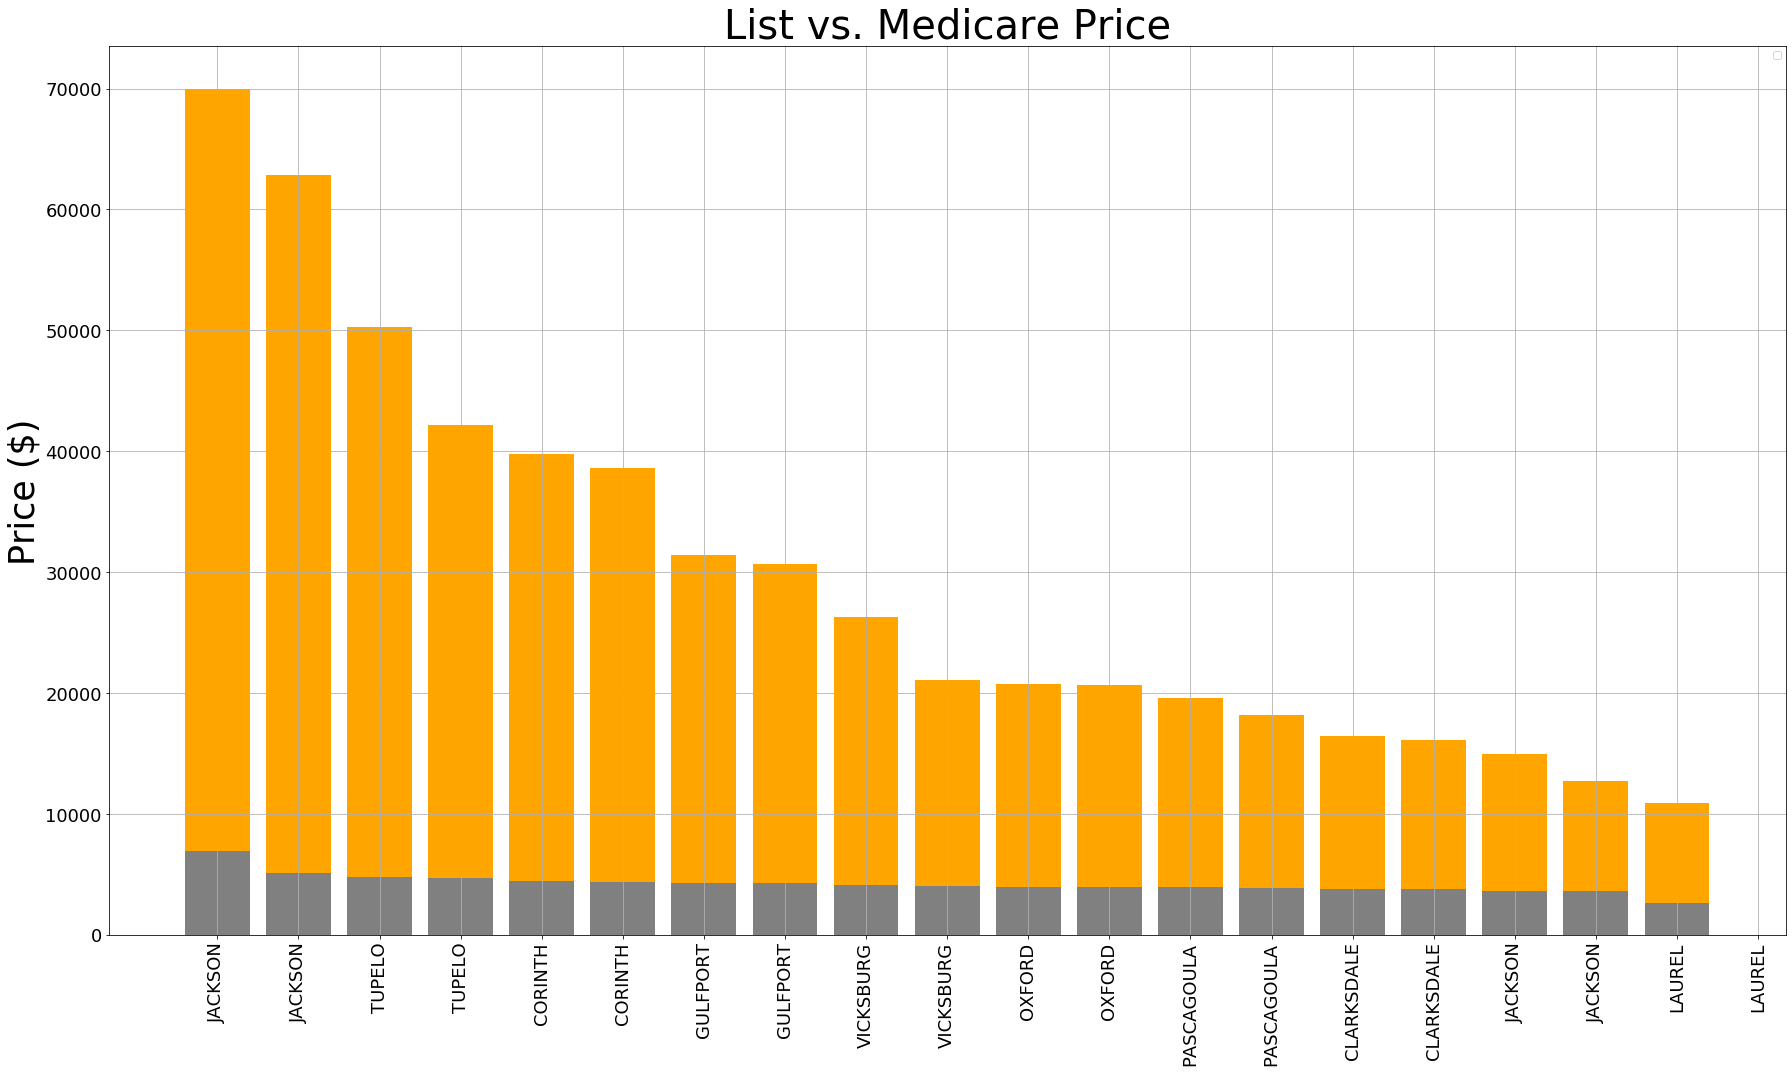

In [13]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(diabetes_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, diabetes_zipcode, rotation=90, size = font)
plt.yticks (size = font)

#Plot Bar Charts
ax.bar(diabetes_zipcode, diabetes_state_list, color='orange', alpha=1, align="center")
ax.bar(diabetes_zipcode, diabetes_state_medicare, color='gray', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price",size = 40)
plt.ylabel("Price ($)",size = 35)
plt.grid(True)
fig.tight_layout()
plt.legend()

In [14]:
#Examine Mississippi, Joint
joint_state_list = []
joint_state_medicare = []
joint_zipcode = []

for i in range (len(joint_master)):
    if joint_master.iloc[i]['State'] == 'MS':
        joint_state_list.append(joint_master.iloc[i]['List Price'])
        joint_state_medicare.append(joint_master.iloc[i]['Average Medicare'])
        joint_zipcode.append(joint_master.iloc[i]['City'])
        
joint_state_list.sort(reverse=True)
joint_state_medicare.sort(reverse=True)

No handles with labels found to put in legend.


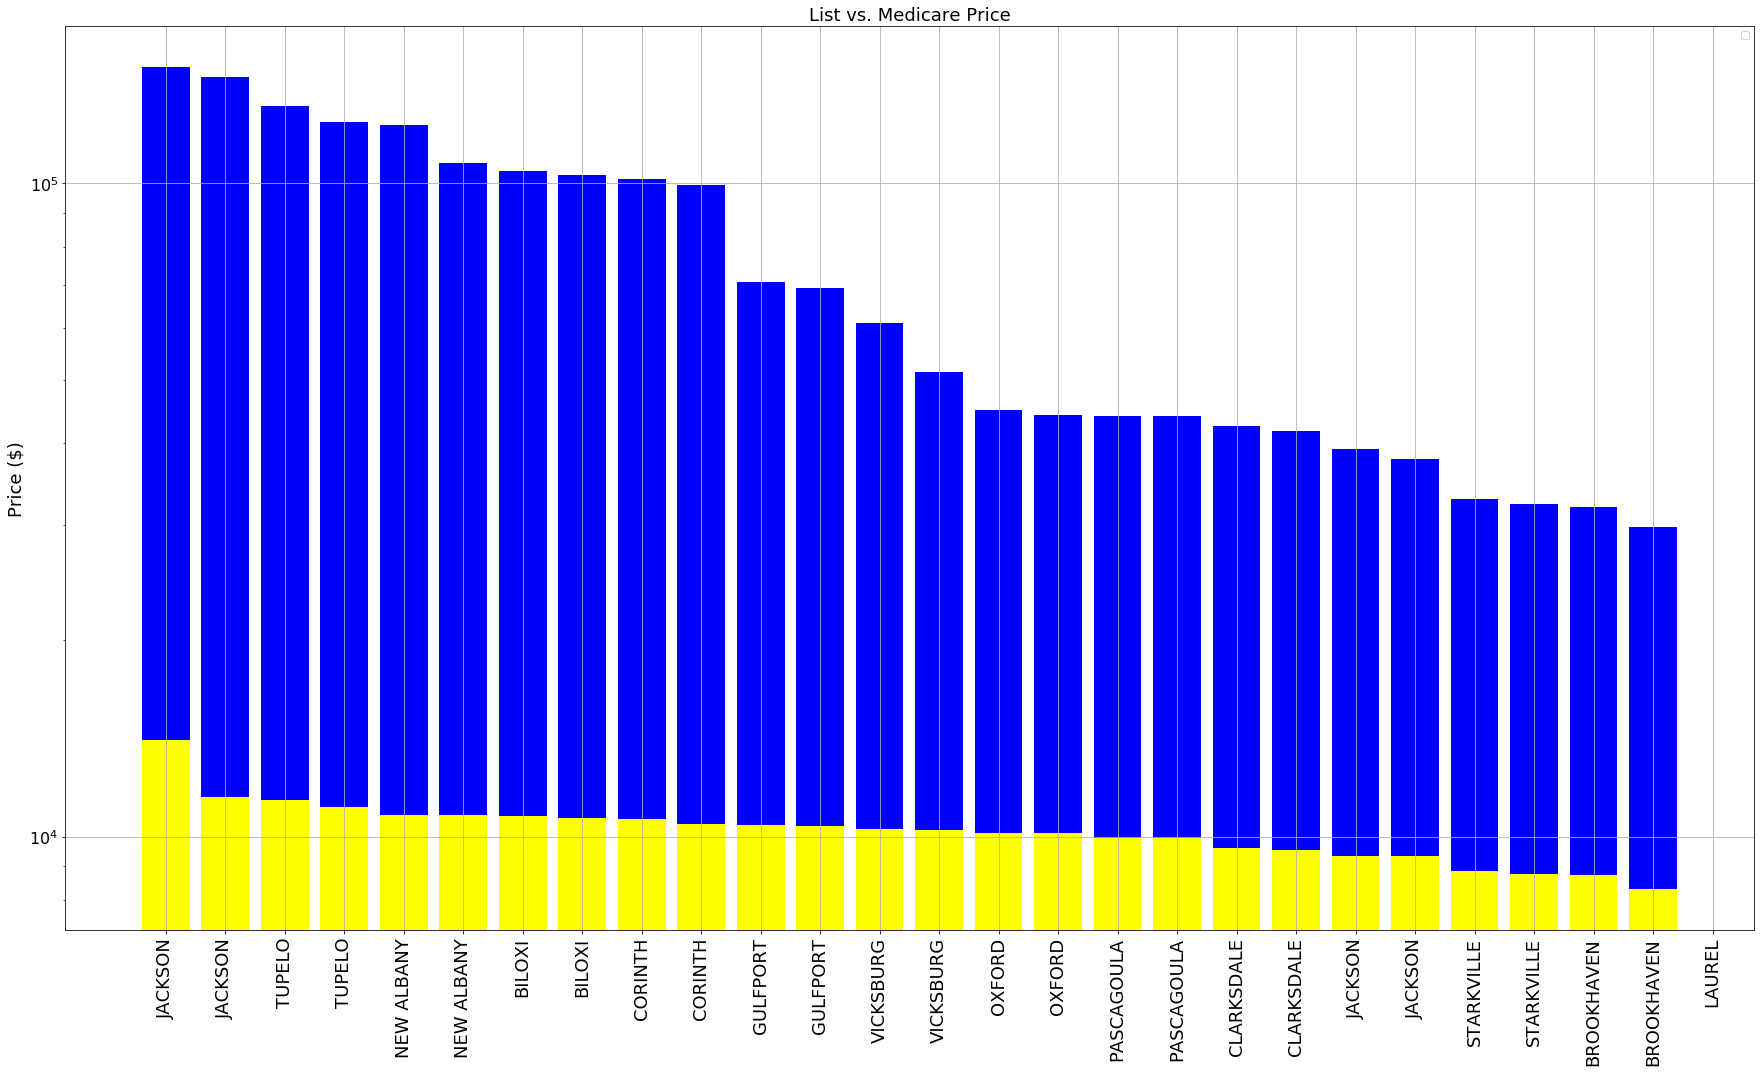

In [15]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(joint_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, joint_zipcode, size = font, rotation=90)
plt.yticks (size = '16')

#Plot Bar Charts
ax.bar(joint_zipcode, joint_state_list, color='Blue', alpha=1, align="center")
ax.bar(joint_zipcode, joint_state_medicare, color='yellow', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price", size = font)
plt.ylabel("Price ($)", size = font)
plt.grid(True)
plt.legend()
fig.tight_layout()
ax.set_yscale('log')

In [16]:
#GMAPS PREP - Convert st_dev dataframe Lat, Long columns to float, supporting Heatmaps 

#diabetes
diabetes_stdev.dropna(inplace=True)

m = pd.to_numeric(diabetes_stdev['Latitude'])
diabetes_stdev['Latitude'] = m

n = pd.to_numeric(diabetes_stdev['Longitude'])
diabetes_stdev['Longitude'] = n

#joint
joint_stdev.dropna(inplace=True)

m = pd.to_numeric(joint_stdev['Latitude'])
joint_stdev['Latitude'] = m

n = pd.to_numeric(joint_stdev['Longitude'])
joint_stdev['Longitude'] = n

In [34]:
#gmaps.Map()

#Set Locations, Weights - can modify weights with new column
locations = diabetes_stdev[['Latitude', 'Longitude']]
weights = diabetes_stdev['List Price']

m = gmaps.figure()
m.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=30.0))
m

Figure(layout=FigureLayout(height='420px'))

In [18]:
#Drill into Mississippi - DIABETES
diabetes_ms = diabetes_master.loc[diabetes_master['State'] == 'MS']
#Drop duplicate rows, sort descending List Price
diabetes_ms.drop_duplicates(subset = 'Provider Id', keep = 'first', inplace = True)
diabetes_ms.sort_values(by='List Price', ascending=False).head()
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,DRG,Provider Id,Name_x,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,...,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,State_y,Latitude_y,Longitude_y
4792,638 - DIABETES W CC,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,11,69990.18,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4778,638 - DIABETES W CC,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,42,62883.50,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4804,638 - DIABETES W CC,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,13,50234.38,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4786,638 - DIABETES W CC,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,42190.21,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4780,638 - DIABETES W CC,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,16,39734.69,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678


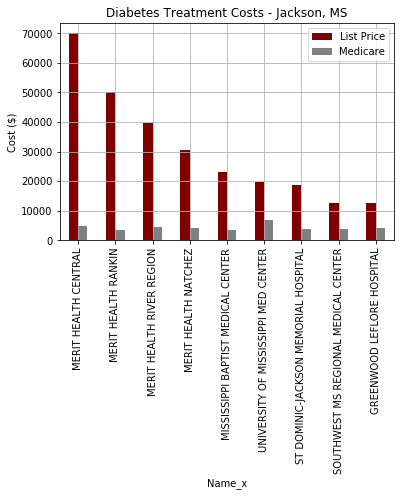

In [19]:
#Drill into Jackson, Mississippi Region - DIABETES
diabetes_jackson = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Jackson']

#Trim dataframe, plot bar graph
diabetes_j = pd.DataFrame({'List Price': (diabetes_jackson['List Price'].values),
                        'Medicare':(diabetes_jackson['Average Medicare'].values)},
                       index=diabetes_jackson['Name_x']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_j.plot.bar(color = my_colors, rot=90)
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.title("Diabetes Treatment Costs - Jackson, MS")
plt.savefig('data/drg638diabetes_jackson.png')

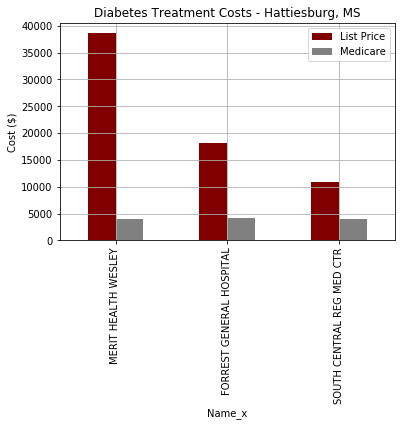

In [20]:
#Drill into Hattiesburg, Mississippi Region - DIABETES
diabetes_hattiesburg = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Hattiesburg']

#Trim dataframe, plot bar graph
diabetes_h = pd.DataFrame({'List Price': (diabetes_hattiesburg['List Price'].values),
                        'Medicare':(diabetes_hattiesburg['Average Medicare'].values)},
                       index=diabetes_hattiesburg['Name_x']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_h.plot.bar(color = my_colors, rot=90)
plt.title("Diabetes Treatment Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.title("Diabetes Treatment Costs - Hattiesburg, MS")
plt.savefig('data/drg638diabetes_hattiesburg.png')

In [21]:
#Drill into Mississippi - JOINTS
joint_ms = joint_master.loc[joint_master['State'] == 'MS']
#Drop duplicate rows, sort descending List Price
joint_ms.drop_duplicates(subset = 'Provider Id', keep = 'first', inplace = True)
joint_ms.sort_values(by='List Price', ascending=False)
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,DRG,Provider Id,Name_x,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,...,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,State_y,Latitude_y,Longitude_y
4714,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250007,MERIT HEALTH BILOXI,150 REYNOIR STREET,BILOXI,MS,39530,MS - Gulfport,51,150442.92,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4738,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,40,145655.78,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4750,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,16,131377.62,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4726,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,124303.07,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4764,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250138,MERIT HEALTH RIVER OAKS,1030 RIVER OAKS DRIVE,FLOWOOD,MS,39232,MS - Jackson,212,122952.75,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4718,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,231,107512.24,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4762,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250123,GARDEN PARK MEDICAL CENTER,15200 COMMUNITY ROAD,GULFPORT,MS,39503,MS - Gulfport,112,104291.79,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4746,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250093,BOLIVAR MEDICAL CENTER,901 E SUNFLOWER RD,CLEVELAND,MS,38732,TN - Memphis,21,103158.76,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4720,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,37,101680.00,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678
4744,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250084,MERIT HEALTH NATCHEZ,52 SERGEANT PRENTISS DRIVE,NATCHEZ,MS,39120,MS - Jackson,26,99335.04,...,2976872,36.2,39031,20618,653321,21.94656,5.010225,Mississippi,32.7364,-89.6678


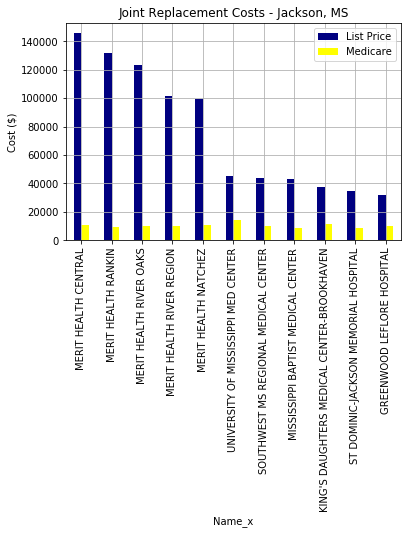

In [22]:
#Drill into Jackson, Mississippi Region - JOINT
joint_jackson = joint_ms.loc[joint_ms['Region'] == 'MS - Jackson']
joint_jackson.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_j = pd.DataFrame({'List Price': (joint_jackson['List Price'].values),
                        'Medicare':(joint_jackson['Average Medicare'].values)},
                       index=joint_jackson['Name_x']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_j.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Jackson, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.savefig('data/drg470joint_jacksonville.png')

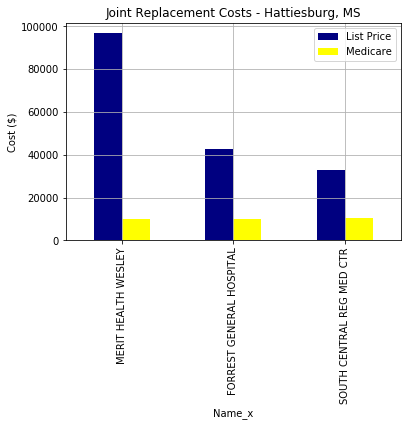

In [23]:
#Drill into Gulfport, Mississippi Region - JOINT
joint_hattiesburg = joint_ms.loc[joint_ms['Region'] == 'MS - Hattiesburg']
joint_hattiesburg.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_h = pd.DataFrame({'List Price': (joint_hattiesburg['List Price'].values),
                        'Medicare':(joint_hattiesburg['Average Medicare'].values)},
                       index=joint_hattiesburg['Name_x']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_h.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.savefig('data/drg470joint_hattiesburg.png')

In [24]:
#Read in joint and diabetes datasets with ratings.
joint_ratings_master = pd.read_csv('data/charge_survey_JOINT_LEFT_Mrgdata.csv')
diabetes_ratings_master = pd.read_csv('data/charge_survey_DIABETES_LEFT_Mrgdata.csv')

joint_ratings = joint_ratings_master.drop(['Readmission national comparison footnote', 'Patient experience national comparison footnote',
                                           'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote',
                                           'Efficient use of medical imaging national comparison footnote',
                                           'Hospital overall rating footnote','Mortality national comparison footnote',
                                           'Safety of care national comparison footnote'],axis=1)
diabetes_ratings = diabetes_ratings_master.drop(['Readmission national comparison footnote', 'Patient experience national comparison footnote',
                                           'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote',
                                           'Efficient use of medical imaging national comparison footnote',
                                           'Hospital overall rating footnote','Mortality national comparison footnote',
                                           'Safety of care national comparison footnote'],axis=1)
diabetes_ratings.head(1)

,DRG Definition,Provider ID,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,...,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison
0,638 - DIABETES W CC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,46,22621.0,...,Yes,Y,3,Same as the national average,Above the national average,Below the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average


In [25]:
#Enumerate the descriptive comparables ratings: 3, 2, 1
diabetes_ratings = diabetes_ratings.replace(['Above the national average'],3)
diabetes_ratings = diabetes_ratings.replace(['Same as the national average'], 2)
diabetes_ratings = diabetes_ratings.replace(['Below the national average'], 1)

joint_ratings = joint_ratings.replace(['Above the national average'], '3')
joint_ratings = joint_ratings.replace(['Same as the national average'], '2')
joint_ratings = joint_ratings.replace(['Below the national average'], '1')

#Convert to numeric
diabetes_ratings['Mortality national comparison'] = pd.to_numeric(diabetes_ratings['Mortality national comparison'],errors='coerce')
diabetes_ratings['Safety of care national comparison'] = pd.to_numeric(diabetes_ratings['Safety of care national comparison'],errors='coerce')
diabetes_ratings['Readmission national comparison'] = pd.to_numeric(diabetes_ratings['Readmission national comparison'],errors='coerce')
diabetes_ratings['Patient experience national comparison'] = pd.to_numeric(diabetes_ratings['Patient experience national comparison'],errors='coerce')
diabetes_ratings['Effectiveness of care national comparison'] = pd.to_numeric(diabetes_ratings['Effectiveness of care national comparison'],errors='coerce')
diabetes_ratings['Timeliness of care national comparison'] = pd.to_numeric(diabetes_ratings['Timeliness of care national comparison'],errors='coerce')
diabetes_ratings['Efficient use of medical imaging national comparison'] = pd.to_numeric(diabetes_ratings['Efficient use of medical imaging national comparison'],errors='coerce')
diabetes_ratings['Hospital overall rating'] = pd.to_numeric(diabetes_ratings['Hospital overall rating'],errors='coerce')

joint_ratings['Mortality national comparison'] = pd.to_numeric(joint_ratings['Mortality national comparison'],errors='coerce')
joint_ratings['Safety of care national comparison'] = pd.to_numeric(joint_ratings['Safety of care national comparison'],errors='coerce')
joint_ratings['Readmission national comparison'] = pd.to_numeric(joint_ratings['Readmission national comparison'],errors='coerce')
joint_ratings['Patient experience national comparison'] = pd.to_numeric(joint_ratings['Patient experience national comparison'],errors='coerce')
joint_ratings['Effectiveness of care national comparison'] = pd.to_numeric(joint_ratings['Effectiveness of care national comparison'],errors='coerce')
joint_ratings['Timeliness of care national comparison'] = pd.to_numeric(joint_ratings['Timeliness of care national comparison'],errors='coerce')
joint_ratings['Efficient use of medical imaging national comparison'] = pd.to_numeric(joint_ratings['Efficient use of medical imaging national comparison'],errors='coerce')
joint_ratings['Hospital overall rating'] = pd.to_numeric(joint_ratings['Hospital overall rating'],errors='coerce')

joint_ratings.to_csv('data/joint_numeric.csv',encoding='utf-8')
diabetes_ratings.to_csv('data/diabetes_numeric.csv',encoding='utf-8')

In [26]:
#Read Brandon's mergered data sources
diabetes_ms = pd.read_csv('data/MS_chg_survey_nums_census_Nat_Diabetes_Frmtd_.csv')
joint_ms = pd.read_csv('data/MS_chg_survey_nums_census_Nat_Joint_Frmtd_.csv')

#Drop NaN, blank rows
diabetes_ms1 = diabetes_ms.dropna()
joint_ms1 = joint_ms.dropna()

#Drop Merit Healthcare deviants
diabetes_ms2 = pd.read_csv('data/diabetes_no_merit.csv').dropna()
joint_ms2 = pd.read_csv('data/joint_no_merit.csv').dropna()

T-Test: T-Value = -10.393641445884066, pvalue = 1.5653853256619052e-08
Linear Regression: Slope = -2.585994347816789, Intercept = 49622.395839073986, Pvalue = 0.7385288340811982, R^2=0.007650270572038645
Polynomial Regression:             4             3          2
-8.546e-08 x + 0.0004238 x - 0.6764 x + 366.3 x + 1.079e+04


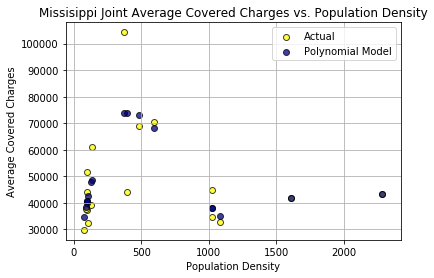

In [27]:
### JOINTS - MS - Hypothesis 1
###Hypothesis: There is a significant difference between income and customer satisfaction.
###Null: There is no significant difference between income and customer satisfaction 

from scipy import stats
#######################Enter Parameter
param = 'Population Density'
#######################################
param2 = 'Average Covered Charges'
# Create two samples
s1 = joint_ms2[param]
s2 = joint_ms2[param2]

# Run T test
(t_stat, p) = stats.ttest_ind(s1, s2, equal_var=False)
print(f"T-Test: T-Value = {t_stat}, pvalue = {p}")

#Run Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(s1, s2)
print(f"Linear Regression: Slope = {slope}, Intercept = {intercept}, Pvalue = {p_value}, R^2={r_value**2}")

# Run Polynomial Regression
z = np.polyfit(s1, s2, 4)
f = np.poly1d(z)
print (f'Polynomial Regression: {f}')

# Scatterplot overlays - actual vs. preducted
#x_new = np.linspace(s2.iloc[0], s2.iloc[22], 30)
y_new = f(s1)

#Original Data
x_data = []
y_data = []
x_data = s1
y_data = s2

#Plot format
fig, ax = plt.subplots()
a=plt.scatter(s1,s2, marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)
b=plt.scatter(s1,y_new, marker="o", facecolors="navy", edgecolors="black",alpha=0.75)

plt.title(f'Missisippi Joint {param2} vs. {param}')
plt.xlabel(f'{param}')
plt.ylabel(param2)
plt.legend((a, b), ('Actual', 'Polynomial Model'))
plt.grid(True)
plt.savefig('data/ms_joint_no_merit.png')

T-Test: T-Value = -11.24463528438743, pvalue = 1.7856502073931564e-07
Linear Regression: Slope = 0.09737376883056005, Intercept = 20709.282317061916, Pvalue = 0.972821015998601, R^2=0.0001220131303265545
Polynomial Regression:             4             3          2
-8.546e-08 x + 0.0004238 x - 0.6764 x + 366.3 x + 1.079e+04
(array([-2.94651669e-08,  1.45197874e-04, -2.28287344e-01,  1.21776690e+02,
        8.00219801e+03]), array([1.54312448e+08]), 5, array([2.03009308, 0.88186965, 0.31381064, 0.05022923, 0.00528543]), 2.6645352591003757e-15)


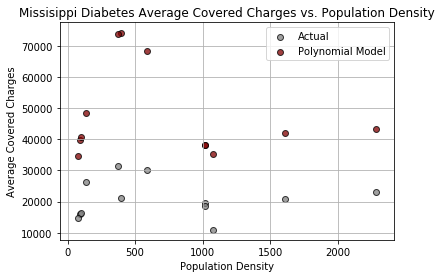

In [28]:
### DIABETES - MS - Hypothesis 1
###Hypothesis: There is a significant difference between income and customer satisfaction.
###Null: There is no significant difference between income and customer satisfaction 

from scipy import stats
#######################Enter Parameter
param = 'Population Density'
#######################################
param2 = 'Average Covered Charges'
# Create two samples
ss1 = diabetes_ms2[param]
ss2 = diabetes_ms2[param2]

# Run T test
(t_stat, p) = stats.ttest_ind(ss1, ss2, equal_var=False)
print(f"T-Test: T-Value = {t_stat}, pvalue = {p}")

#Run Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(ss1, ss2)
print(f"Linear Regression: Slope = {slope}, Intercept = {intercept}, Pvalue = {p_value}, R^2={r_value**2}")

# Run Polynomial Regression
z = np.polyfit(s1, s2, 4)
f = np.poly1d(z)

print (f'Polynomial Regression: {f}')

zz = np.polyfit(ss1,ss2, 4, full=True)
print (zz)

# Scatterplot overlays - actual vs. preducted
#x_new = np.linspace(s2.iloc[0], s2.iloc[22], 30)
y_new = f(ss1)

#Original Data
x_data = []
y_data = []
x_data = ss1
y_data = ss2

#Plot format
fig, ax = plt.subplots()
aa=plt.scatter(ss1,ss2, marker="o", facecolors="gray", edgecolors="black",alpha=0.75)
bb=plt.scatter(ss1,y_new, marker="o", facecolors="maroon", edgecolors="black",alpha=0.75)

plt.title(f'Missisippi Diabetes {param2} vs. {param}')
plt.xlabel(f'{param}')
plt.ylabel(param2)
plt.grid(True)
plt.legend((aa, bb), ('Actual', 'Polynomial Model'))
plt.savefig('data/ms_diabetes_no_merit.png')

In [29]:
#Hypothesis 3 - Private Hospitals shown higher standard deviation
joint_prop = joint_ms1.loc[joint_ms1['Hospital Ownership'] == 'Proprietary']
joint_gov = joint_ms1.loc[joint_ms1['Hospital Ownership'] == 'Government - Local']
joint_vol = joint_ms1.loc[joint_ms1['Hospital Ownership'] == 'Voluntary non-profit - Private']
a = len(joint_prop)
b = len(joint_gov)
c = len(joint_vol)
diabetes_prop = diabetes_ms1.loc[diabetes_ms1['Hospital Ownership'] == 'Proprietary']
diabetes_gov = diabetes_ms1.loc[diabetes_ms1['Hospital Ownership'] == 'Government - Local']
diabetes_vol = diabetes_ms1.loc[diabetes_ms1['Hospital Ownership'] == 'Voluntary non-profit - Private']
aa = len(joint_prop)
bb = len(joint_gov)
cc = len(joint_vol)

print ('JOINTS:  Proprietary StDev: ',a, joint_prop['Average Covered Charges'].std(), 
       ', Governement StDev: ',b, joint_gov['Average Covered Charges'].std(), 
       ', Non-Profit StDev: ',c, joint_vol['Average Covered Charges'].std())

print ('DIABETES:  Proprietary StDev: ',aa, diabetes_prop['Average Covered Charges'].std(), 
       ', Governement StDev: ',bb, diabetes_gov['Average Covered Charges'].std(), 
       ', Non-Profit StDev: ',cc, diabetes_vol['Average Covered Charges'].std())

JOINTS:  Proprietary StDev:  6 22803.307759518582 , Governement StDev:  3 20249.252469714364 , Non-Profit StDev:  9 20298.65592581748
DIABETES:  Proprietary StDev:  6 18483.404923913953 , Governement StDev:  3 13533.090410959352 , Non-Profit StDev:  9 8111.458500788515


In [30]:
#Hypothesis 2 - There is a significant different between population density and medical procedure cost.
joint_rural = joint_ms1.loc[joint_ms1['region cat'] == 'rural']
joint_suburban = joint_ms1.loc[joint_ms1['region cat'] == 'suburban']
diabetes_rural = diabetes_ms1.loc[diabetes_ms1['region cat'] == 'rural']
diabetes_suburban = diabetes_ms1.loc[diabetes_ms1['region cat'] == 'suburban']

##Calculate Average Covered Costs, sample size for each group
d_rural = diabetes_rural['Average Covered Charges'].mean()
d_suburban = diabetes_suburban['Average Covered Charges'].mean()
j_rural = joint_rural['Average Covered Charges'].mean()
j_suburban = joint_suburban['Average Covered Charges'].mean()
print (d_rural, len(diabetes_rural))
print (d_suburban, len(diabetes_suburban))
print (j_rural, len(joint_rural))
print (j_suburban, len(joint_suburban))

26530.976000000002 10
27182.678333333333 6
70141.04764705885 17
57164.611666666664 6


In [31]:
#Read Tyler's National Ratings data + Merge
ratings_master = pd.read_csv('data/ratings_dump.csv')
drg_diabetes = pd.read_csv('data/drg_diabetes.csv')
#Strip out 'Star Ratings'
ratings_star = ratings_master.loc[ratings_master['Function'] == 'Star Ratings']

#Inner Merge, ratings with drg_diabetes costs
ratings = pd.merge(drg_diabetes, ratings_star, on='Provider Id', how='inner').dropna()
ratings.to_csv('data/ratings.csv',encoding='utf-8')
len(ratings)

1578

T-Test: T-Value = -73.18081389444465, pvalue = 0.0
Linear Regression: Slope = -247.8486204326963, Intercept = 39475.26258752547, Pvalue = 5.870203165162494e-36, R^2=0.09468995132269074
Polynomial Regression:  
-247.8 x + 3.948e+04
[ -247.84862043 39475.26258753]


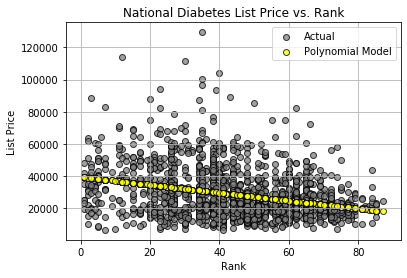

In [32]:
###Hypothesis: There is a significant difference between ratings and average covered charges ('list price').

#######################Enter Parameter
param = 'Rank'
#######################################
param2 = 'List Price'
# Create two samples
ss1 = ratings[param]
ss2 = ratings[param2]

# Run T test
(t_stat, p) = stats.ttest_ind(ss1, ss2, equal_var=False)
print(f"T-Test: T-Value = {t_stat}, pvalue = {p}")

#Run Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(ss1, ss2)
print(f"Linear Regression: Slope = {slope}, Intercept = {intercept}, Pvalue = {p_value}, R^2={r_value**2}")

# Run Polynomial Regression
z = np.polyfit(ss1, ss2, 1)
zz = np.polyfit(ss1,ss2, 1)
f = np.poly1d(z)
print (f'Polynomial Regression: {f}')
print(zz)

# Scatterplot overlays - actual vs. preducted
y_new = f(ss1)

#Original Data
x_data = []
y_data = []
x_data = ss1
y_data = ss2

#Plot format
fig, ax = plt.subplots()
aa=plt.scatter(ss1,ss2, marker="o", facecolors="gray", edgecolors="black",alpha=0.75)
bb=plt.scatter(ss1,y_new, marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)

plt.title(f'National Diabetes {param2} vs. {param}')
plt.xlabel(f'{param}')
plt.ylabel(param2)
plt.grid(True)
plt.legend((aa, bb), ('Actual', 'Polynomial Model'))
plt.savefig('data/national_diabetes_star_rating.png')